# Easy Money Case

## Import of Libreries

In [40]:
import sys 

import os 
import random

import numpy as np 
import pandas as pd 

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 

# Necesarios para leer el fichero de Google Analytics
import json 
from pandas.io.json import json_normalize 

pd.options.display.max_rows = 999

plt.style.use('ggplot')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

## Import of Dataset

### Products

In [42]:
products = pd.read_csv('products_df.csv')

In [43]:
products.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Columns: 18 entries, Unnamed: 0 to em_acount
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [44]:
products.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
pk_cid,1375586,1050611,1050612,1050613,1050614
pk_partition,2018-01-28,2018-01-28,2018-01-28,2018-01-28,2018-01-28
short_term_deposit,0,0,0,1,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0
securities,0,0,0,0,0
long_term_deposit,0,0,0,0,0
em_account_pp,0,0,0,0,0


In [45]:
products.set_index(['pk_cid', 'pk_partition'], inplace=True)

In [46]:
products.drop(products.columns[products.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

##### Vamos a convertir el dataset haciendo que una transacción solo pertenezca a un 1. 

In [47]:
products_pk = products.copy()

In [48]:
products_pk.sort_index(inplace=True)

In [49]:
products_pk[products_pk.groupby(level=0).pct_change() <= 0 ] = 0

In [50]:
products_pk

short_term_deposit  loans  mortgage  funds  securities  \
pk_cid  pk_partition                                                           
15891   2018-07-28                     0      0         0      0           0   
        2018-08-28                     0      0         0      0           0   
16063   2018-11-28                     0      0         0      0           0   
        2018-12-28                     0      0         0      0           0   
        2019-01-28                     0      0         0      0           0   
...                                  ...    ...       ...    ...         ...   
1553685 2019-05-28                     0      0         0      0           0   
1553686 2019-05-28                     0      0         0      0           0   
1553687 2019-05-28                     0      0         0      0           0   
1553688 2019-05-28                     0      0         0      0           0   
1553689 2019-05-28                     0      0         0      0           0   

                      long_term_deposit  em_account_pp  credit_card  payroll  \
pk_cid  pk_partition                                                           
15891   2018-07-28                    0              0            0      0.0   
        2018-08-28                    0              0            0      0.0   
16063   2018-11-28                    0              0            0      0.0   
        2018-12-28                    0              0            0      0.0   
        2019-01-28                    0              0            0      0.0   
...                                 ...            ...          ...      ...   
1553685 2019-05-28                    0              0            0      0.0   
1553686 2019-05-28                    0              0            0      0.0   
1553687 2019-05-28                    0              0            0      0.0   
1553688 2019-05-28                    0              0            0      0.0   
1553689 2019-05-28                    0              0            0      0.0   

                      pension_plan  payroll_account  emc_account  debit_card  \
pk_cid  pk_partition                                                           
15891   2018-07-28             0.0                0            0           0   
        2018-08-28             0.0                0            0           0   
16063   2018-11-28             0.0                0            0           0   
        2018-12-28             0.0                0            0           0   
        2019-01-28             0.0                0            0           0   
...                            ...              ...          ...         ...   
1553685 2019-05-28             0.0                0            0           0   
1553686 2019-05-28             0.0                0            0           0   
1553687 2019-05-28             0.0                0            0           0   
1553688 2019-05-28             0.0                0            0           0   
1553689 2019-05-28             0.0                0            0           0   

                      em_account_p  em_acount  
pk_cid  pk_partition                           
15891   2018-07-28               0          1  
        2018-08-28               0          0  
16063   2018-11-28               0          0  
        2018-12-28               0          0  
        2019-01-28               0          0  
...                            ...        ...  
1553685 2019-05-28               0          0  
1553686 2019-05-28               0          0  
1553687 2019-05-28               0          0  
1553688 2019-05-28               0          0  
1553689 2019-05-28               0          0  

[5962924 rows x 15 columns]

### ComercialActivity

In [51]:
comercial_activity = pd.read_csv('commercial_activity_df.csv', index_col = ['pk_cid', 'pk_partition'])

C:\Users\charl\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [52]:
comercial_activity.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5962924 entries, (1375586, 2018-01-28) to (1550586, 2019-05-28)
Data columns (total 5 columns):
Unnamed: 0         int64
entry_date         object
entry_channel      object
active_customer    float64
segment            object
dtypes: float64(1), int64(1), object(3)
memory usage: 259.4+ MB


In [53]:
comercial_activity.head(2).T

pk_cid,1375586,1050611
pk_partition,2018-01-28,2018-01-28
Unnamed: 0,0,1
entry_date,2018-01-12,2015-08-10
entry_channel,KHL,KHE
active_customer,1,0
segment,02 - PARTICULARES,03 - UNIVERSITARIO


In [54]:
comercial_activity.shape

(5962924, 5)

In [55]:
comercial_activity.drop(columns='Unnamed: 0', inplace=True)

In [56]:
comercial_activity.loc[17457]

,entry_date,entry_channel,active_customer,segment
pk_partition,,,,
2018-01-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-02-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-03-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-04-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-05-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-06-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-07-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-08-28,2017-09-16,KAT,1.0,02 - PARTICULARES
2018-09-28,2017-09-16,KAT,1.0,02 - PARTICULARES


### SocioDemographic

In [57]:
socio_demographic = pd.read_csv('sociodemographic_df.csv', index_col = ['pk_cid', 'pk_partition'])

In [58]:
socio_demographic.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5962924 entries, (1375586, 2018-01-28) to (1550586, 2019-05-28)
Data columns (total 7 columns):
Unnamed: 0     int64
country_id     object
region_code    float64
gender         object
age            int64
deceased       object
salary         float64
dtypes: float64(2), int64(2), object(3)
memory usage: 350.4+ MB


In [59]:
socio_demographic.head(2).T

pk_cid,1375586,1050611
pk_partition,2018-01-28,2018-01-28
Unnamed: 0,0,1
country_id,ES,ES
region_code,29,13
gender,H,V
age,35,23
deceased,N,N
salary,87218.1,35548.7


In [60]:
socio_demographic.drop(columns='Unnamed: 0', inplace=True)

In [61]:
socio_demographic.loc[17457]

,country_id,region_code,gender,age,deceased,salary
pk_partition,,,,,,
2018-01-28,ES,28.0,H,53,N,102405.75
2018-02-28,ES,28.0,H,53,N,102405.75
2018-03-28,ES,28.0,H,53,N,102405.75
2018-04-28,ES,28.0,H,53,N,102405.75
2018-05-28,ES,28.0,H,53,N,102405.75
2018-06-28,ES,28.0,H,53,N,102405.75
2018-07-28,ES,28.0,H,53,N,102405.75
2018-08-28,ES,28.0,H,53,N,102405.75
2018-09-28,ES,28.0,H,53,N,102405.75


In [62]:
socio_demographic.describe()

,region_code,age,salary
count,5.960660e+06,5.962924e+06,4.450821e+06
mean,2.581440e+01,2.976042e+01,1.158167e+05
std,1.359566e+01,1.198038e+01,1.995519e+05
min,1.000000e+00,2.000000e+00,1.202730e+03
25%,1.300000e+01,2.200000e+01,6.150063e+04
50%,2.800000e+01,2.500000e+01,8.865465e+04
75%,3.600000e+01,3.400000e+01,1.316699e+05
max,5.200000e+01,1.050000e+02,2.889440e+07


### Dataset unification

In [63]:
df = pd.concat([products_pk, comercial_activity, socio_demographic], axis=1)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5962924 entries, (15891, 2018-07-28) to (1553689, 2019-05-28)
Data columns (total 25 columns):
short_term_deposit    int64
loans                 int64
mortgage              int64
funds                 int64
securities            int64
long_term_deposit     int64
em_account_pp         int64
credit_card           int64
payroll               float64
pension_plan          float64
payroll_account       int64
emc_account           int64
debit_card            int64
em_account_p          int64
em_acount             int64
entry_date            object
entry_channel         object
active_customer       float64
segment               object
country_id            object
region_code           float64
gender                object
age                   int64
deceased              object
salary                float64
dtypes: float64(5), int64(14), object(6)
memory usage: 1.1+ GB


In [65]:
df.head().T

pk_cid                   15891                          16063  \
pk_partition        2018-07-28         2018-08-28  2018-11-28   
short_term_deposit           0                  0           0   
loans                        0                  0           0   
mortgage                     0                  0           0   
funds                        0                  0           0   
securities                   0                  0           0   
long_term_deposit            0                  0           0   
em_account_pp                0                  0           0   
credit_card                  0                  0           0   
payroll                      0                  0           0   
pension_plan                 0                  0           0   
payroll_account              0                  0           0   
emc_account                  0                  0           0   
debit_card                   0                  0           0   
em_account_p                 0                  0           0   
em_acount                    1                  0           0   
entry_date          2018-07-28         2018-07-28  2018-11-19   
entry_channel              KAT                KAT         KAT   
active_customer              1                  0           1   
segment                    NaN  02 - PARTICULARES         NaN   
country_id                  ES                 ES          ES   
region_code                 28                 28          28   
gender                       H                  H           H   
age                         59                 59          62   
deceased                     N                  N           N   
salary                     NaN                NaN         NaN   

pk_cid                                                    
pk_partition               2018-12-28         2019-01-28  
short_term_deposit                  0                  0  
loans                               0                  0  
mortgage                            0                  0  
funds                               0                  0  
securities                          0                  0  
long_term_deposit                   0                  0  
em_account_pp                       0                  0  
credit_card                         0                  0  
payroll                             0                  0  
pension_plan                        0                  0  
payroll_account                     0                  0  
emc_account                         0                  0  
debit_card                          0                  0  
em_account_p                        0                  0  
em_acount                           0                  0  
entry_date                 2018-11-19         2018-11-19  
entry_channel                     KAT                KAT  
active_customer                     1                  1  
segment             02 - PARTICULARES  02 - PARTICULARES  
country_id                         ES                 ES  
region_code                        28                 28  
gender                              H                  H  
age                                62                 62  
deceased                            N                  N  
salary                            NaN                NaN

In [66]:
df.loc[17457].T

pk_partition,2018-01-28,2018-02-28,2018-03-28,2018-04-28,2018-05-28,2018-06-28,2018-07-28,2018-08-28,2018-09-28,2018-10-28,2018-11-28,2018-12-28,2019-01-28,2019-02-28,2019-03-28,2019-04-28,2019-05-28
short_term_deposit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
funds,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
securities,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long_term_deposit,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
em_account_pp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
credit_card,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
payroll,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pension_plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Joining by pk_cid

In [67]:
stats_desc = []
for col in df.columns:
    stats_desc.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(stats_desc, columns=['Feature', 'Unique_values', '% de nulos', '% de rep. mayor valor', 'type'])
stats_df.sort_values('% de nulos', ascending=False)

,Feature,Unique_values,% de nulos,% de rep. mayor valor,type
24,salary,258629,25.358415,25.358415,float64
18,segment,3,2.246281,65.406938,object
16,entry_channel,68,2.231003,52.221813,object
20,region_code,52,0.037968,19.885496,float64
8,payroll,2,0.001006,99.275104,float64
9,pension_plan,2,0.001006,99.218303,float64
21,gender,2,0.000419,51.778322,object
14,em_acount,2,0.000000,94.173194,int64
23,deceased,2,0.000000,99.981972,object
22,age,104,0.000000,12.194252,int64


Viendo las columnas ya podríamos borrar algunas que sabemos no van a generar ninguna información en el modelo. 

In [68]:
df.drop(['deceased', 'country_id'], axis=1, inplace=True)

Para realizar la agrupación por pk_cid requiero modificar la columna gender. 

In [69]:
df['gender']

pk_cid   pk_partition
15891    2018-07-28      H
         2018-08-28      H
16063    2018-11-28      H
         2018-12-28      H
         2019-01-28      H
                        ..
1553685  2019-05-28      V
1553686  2019-05-28      H
1553687  2019-05-28      V
1553688  2019-05-28      H
1553689  2019-05-28      V
Name: gender, Length: 5962924, dtype: object

In [70]:
df['gender'] = (df['gender'] == 'V')

In [71]:
df['gender'] = df['gender'].astype(int)

In [72]:
df['gender'].describe()

count    5.962924e+06
mean     4.822126e-01
std      4.996835e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: gender, dtype: float64

Ahora si el valor es 1 el cliente es Varon, Si es 0 es hembra.

Retiramos pk_partition del index porque ya no será necesario para identificar al cliente.

In [73]:
df.reset_index(level=1, inplace=True)

##### Hacemos la agrupación por pk_cid. Este es el punto más importante y clave del notebook. 

In [74]:
aggregated_df_ = df.groupby('pk_cid').agg({
    'pk_partition': ['count', 'max', 'min'], #Con el count tenemos número de meses, max último mes, y min primer mes. 
    'short_term_deposit': ['sum'], #número de veces que ha sido comprado el producto.
    'loans': ['sum'], #número de veces que ha sido comprado el producto.
    'mortgage': ['sum'], #número de veces que ha sido comprado el producto.
    'funds': ['sum'], #número de veces que ha sido comprado el producto.
    'securities': ['sum'], #número de veces que ha sido comprado el producto.
    'long_term_deposit': ['sum'], #número de veces que ha sido comprado el producto.
    'em_account_pp': ['sum'], #número de veces que ha sido comprado el producto.
    'credit_card': ['sum'], #número de veces que ha sido comprado el producto.
    'payroll': ['sum'], #número de veces que ha sido comprado el producto.
    'pension_plan': ['sum'], #número de veces que ha sido comprado el producto.
    'payroll_account': ['sum'], #número de veces que ha sido comprado el producto.
    'emc_account': ['sum'], #número de veces que ha sido comprado el producto.
    'debit_card': ['sum'], #número de veces que ha sido comprado el producto.
    'em_account_p': ['sum'], #número de veces que ha sido comprado el producto.
    'em_acount': ['sum'], #número de veces que ha sido comprado el producto.
    'entry_date':['max'], #última fecha registrada de entry date. 
    'active_customer':['mean'], #como es un valor cambiante, colocamos la media para entender el comportamiento. 
    'region_code':['median'], #Aunque todos los cientes cuentan con una sola región. Solo por si un cliente cambia de región, se coloca la mediana. 
    'gender': ['median'], #Claramente ningún cliente cambia de genero. Si fuera así, aparece el genero más repetido. 
    'age': ['max'], #Claramente se coloca la última edad registrada. 
    'salary': ['max'] #Aunque no cambia el salario en cada partición se pone max.
 })

In [75]:
aggregated_df_.columns = [
    'number_partitions',
    'last_partition',
    'first_partition',
    'short_term_deposit',
    'loans',
    'mortgage',
    'funds',
    'securities',
    'long_term_deposit',
    'em_account_pp',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount',
    'entry_date',
    'active_customer_mean',
    'region_code',
    'is_men',
    'age', 
    'salary'       
]

In [81]:
aggregated_df_.columns

Index(['number_partitions', 'last_partition', 'first_partition',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'entry_date', 'active_customer_mean',
       'region_code', 'is_men', 'age', 'salary'],
      dtype='object')

In [82]:
df_agg = aggregated_df_.copy()

In [83]:
%who DataFrame

aggregated_df_	 comercial_activity	 df	 df_agg	 products	 products_pk	 socio_demographic	 stats_df	 


In [84]:
del aggregated_df_
del comercial_activity
del products
del socio_demographic
del products_pk
del stats_df

## Initial EDA

In [85]:
df_agg.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
number_partitions,456373.0,13.065900,4.623960,1.00,10.00,17.00,17.00,17.00
short_term_deposit,456373.0,0.011705,0.107943,0.00,0.00,0.00,0.00,3.00
loans,456373.0,0.000096,0.009819,0.00,0.00,0.00,0.00,1.00
mortgage,456373.0,0.000055,0.007401,0.00,0.00,0.00,0.00,1.00
funds,456373.0,0.003736,0.062534,0.00,0.00,0.00,0.00,4.00
securities,456373.0,0.004917,0.075435,0.00,0.00,0.00,0.00,3.00
long_term_deposit,456373.0,0.020854,0.148990,0.00,0.00,0.00,0.00,2.00
em_account_pp,456373.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
credit_card,456373.0,0.031753,0.267339,0.00,0.00,0.00,0.00,6.00
payroll,456373.0,0.094583,0.443375,0.00,0.00,0.00,0.00,7.00


In [86]:
df_agg.describe(exclude=np.number).T

,count,unique,top,freq
last_partition,456373,11,2019-05-28,442995
first_partition,456373,17,2018-01-28,239493
entry_date,456373,1499,2017-07-28,3469


## EDA

In [87]:
#initial_description = df.describe(include='all').T

In [88]:
#initial_description.to_excel('initial_description.xlsx')

### Entry Date

In [89]:
df_agg['entry_date']

pk_cid
15891      2018-07-28
16063      2018-11-19
16203      2018-12-23
16502      2018-09-30
17457      2017-09-16
              ...    
1553685    2019-05-31
1553686    2019-05-31
1553687    2019-05-31
1553688    2019-05-31
1553689    2019-05-31
Name: entry_date, Length: 456373, dtype: object

In [90]:
df_agg['entry_date'] = pd.to_datetime(df_agg['entry_date'], format='%Y-%m-%d', errors='coerce')

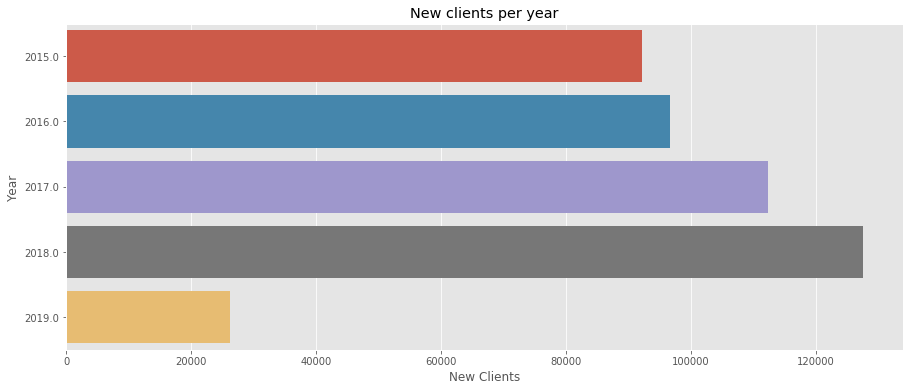

In [91]:
plt.figure(figsize= [15, 6])
ax = sns.countplot(data=df, y=df_agg['entry_date'].dt.year)
plt.xlabel('New Clients')
plt.ylabel('Year')
plt.title("New clients per year")
plt.show()

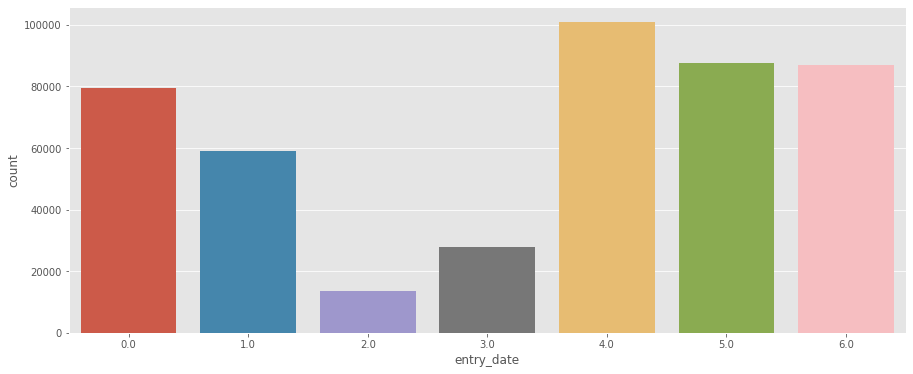

In [92]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df, x=df_agg['entry_date'].dt.weekday)

In [93]:
df_agg['entry_date'].isnull().sum()

1474

Por ser tan pocos valores. Solo se sustituyen por la moda. 

In [94]:
df_agg['entry_date'].fillna(df_agg['entry_date'].mode()[0], inplace=True)

### Active Customer

In [95]:
df_agg['active_customer_mean'].head().T

pk_cid
15891    0.500000
16063    0.714286
16203    0.833333
16502    0.888889
17457    1.000000
Name: active_customer_mean, dtype: float64

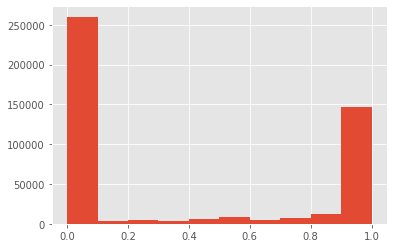

In [96]:
df_agg['active_customer_mean'].hist()

Se logra ver que la mayoría de clientes no presentan cambios en active customer

In [97]:
df_agg['active_customer_mean'].isnull().sum()

0

### region code

In [98]:
df_agg['region_code']

pk_cid
15891      28.0
16063      28.0
16203       8.0
16502      28.0
17457      28.0
           ... 
1553685    13.0
1553686    41.0
1553687    28.0
1553688    39.0
1553689    21.0
Name: region_code, Length: 456373, dtype: float64

In [99]:
df_agg['region_code'].isnull().sum()

146

Sustituimos los valores nulos por un valor que no exista como provincia.

In [100]:
df_agg['region_code'].fillna(value=-999, inplace=True)

In [101]:
df_agg['region_code'] = df_agg['region_code'].astype(int)

Vamos a sustituir el código región por la provincia. 

In [102]:
provincias = pd.read_csv('provincia.csv', index_col=0)

In [103]:
provincias.head()

,provincia
codigo,
1,Alava
2,Albacete
3,Alicante
4,Almería
5,Avila


In [104]:
df_agg = df_agg.join(provincias, how='left', on='region_code')

In [105]:
df_agg['provincia'].isnull().sum()

146

In [106]:
df_agg['provincia'].fillna(value='unknown', inplace=True)

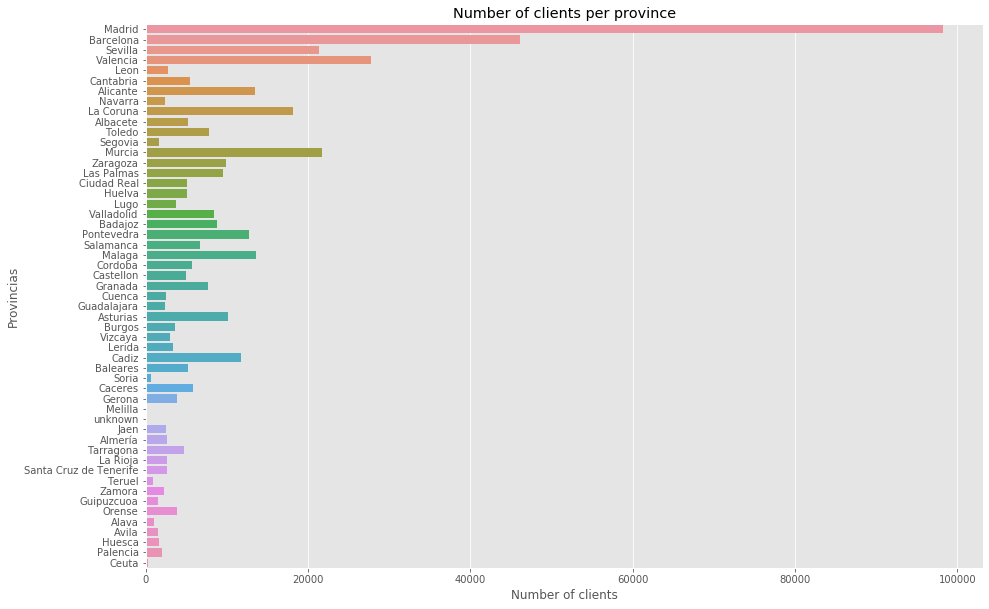

In [107]:
plt.figure(figsize= [15, 10])
sns.countplot(data=df_agg, y=df_agg['provincia'])
plt.xlabel('Number of clients')
plt.ylabel('Provincias')
plt.title("Number of clients per province")
plt.show()

Sustituimos la provincia por su población para que pueda ser procesada por el modelo. 

In [108]:
pob_provincias = pd.read_excel('poblacion_provincia_ult.xls', index_col=0)

In [109]:
pob_provincias.head()

,poblacion
cp,
1,319227
2,402318
3,1934127
4,702819
5,172704


In [110]:
df_agg = df_agg.join(pob_provincias, how='left', on='region_code')

In [111]:
df_agg.head().T

pk_cid,15891,16063,16203,16502,17457
number_partitions,2,7,6,9,17
last_partition,2018-08-28,2019-05-28,2019-05-28,2019-05-28,2019-05-28
first_partition,2018-07-28,2018-11-28,2018-12-28,2018-09-28,2018-01-28
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0
securities,0,0,0,0,0
long_term_deposit,0,0,0,0,2
em_account_pp,0,0,0,0,0


In [112]:
df_agg['poblacion'].describe()

count    4.562270e+05
mean     2.730396e+06
std      2.425482e+06
min      7.847600e+04
25%      8.058570e+05
50%      1.470069e+06
75%      5.529099e+06
max      6.489680e+06
Name: poblacion, dtype: float64

In [113]:
df_agg['poblacion'].isnull().sum()

146

In [114]:
df_agg['poblacion'].fillna(value=-999, inplace=True)

### gender

In [115]:
df_agg['is_men']

pk_cid
15891      0
16063      0
16203      1
16502      0
17457      0
          ..
1553685    1
1553686    0
1553687    1
1553688    0
1553689    1
Name: is_men, Length: 456373, dtype: int32

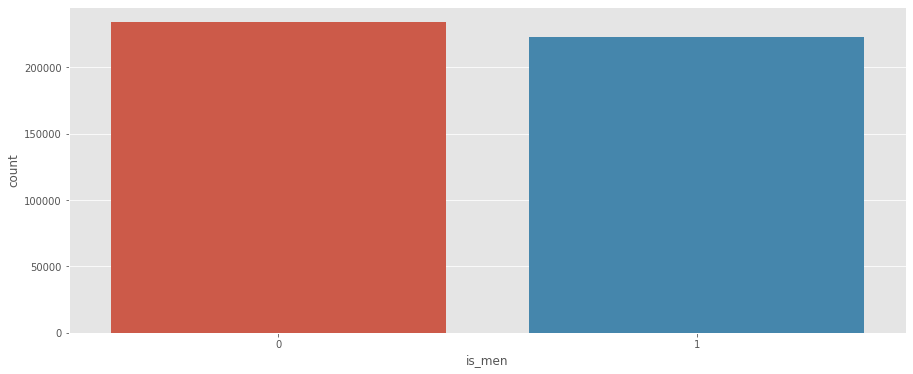

In [116]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg, x='is_men')

In [117]:
df_agg['is_men'].isnull().sum()

0

### age

In [118]:
df_agg['age'].describe()

count    456373.000000
mean         30.605036
std          12.322632
min           2.000000
25%          22.000000
50%          25.000000
75%          36.000000
max         105.000000
Name: age, dtype: float64

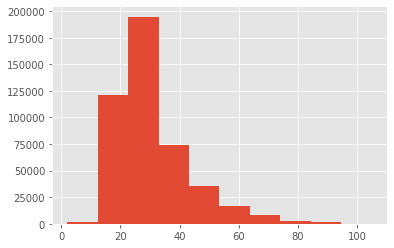

In [119]:
df_agg['age'].hist()

In [120]:
bins= [0,25,30,35,40,50,60,150]
labels = ['-24','25-29','30-34','35-39','40-49', '50-59', '60-']
df_agg['age_group'] = pd.cut(df_agg['age'], bins=bins, labels=labels, right=False)

In [121]:
df_agg['age_group'].head()

pk_cid
15891    50-59
16063      60-
16203      60-
16502    50-59
17457    50-59
Name: age_group, dtype: category
Categories (7, object): [-24 < 25-29 < 30-34 < 35-39 < 40-49 < 50-59 < 60-]

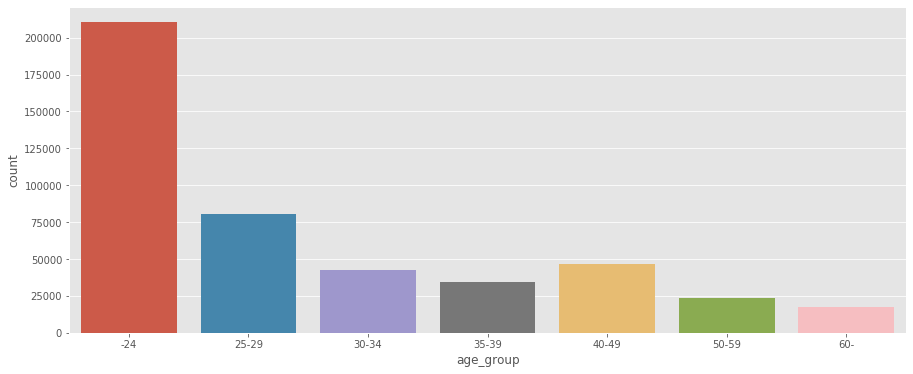

In [122]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg, x='age_group')

In [123]:
df_agg['age_group'].isnull().sum()

0

In [124]:
df_agg['age'].isnull().sum()

0

In [125]:
#df_agg.drop('age', axis=1, inplace=True)

### salary

In [126]:
df['salary'].describe()

count    4.450821e+06
mean     1.158167e+05
std      1.995519e+05
min      1.202730e+03
25%      6.150063e+04
50%      8.865465e+04
75%      1.316699e+05
max      2.889440e+07
Name: salary, dtype: float64

In [127]:
bins= [-10,0,20000,40000,60000,80000,100000,120000,140000,160000,180000,200000,220000,240000,300000, 400000, 500000, 1000000, 3000000]
labels = ['unknown','-20','20-40','40-60','60-80','80-100', '100-120', '120-140','140-160','160-180','180-200','200-220','220-240','240-300','300-400','400-500','500-1000','1000-']
df_agg['salary_group*1000'] = pd.cut(df_agg['salary'], bins=bins, labels=labels, right=False)

In [129]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg, x='age_group', hue='salary')

KeyboardInterrupt: 

<Figure size 1080x432 with 0 Axes>

In [ ]:
df_agg['salary_group*1000'].value_counts()

In [ ]:
df_agg['salary_group*1000'].isnull().sum()

In [ ]:
df_agg['salary_group*1000'].fillna(value='unknown', inplace=True)

In [ ]:
df_agg['salary'].isnull().sum()

In [130]:
df_agg['salary'].fillna(value=-999, inplace=True)

In [ ]:
#df_agg.drop('salary', axis=1, inplace=True)

## New columns

### Number transactions

In [ ]:
df_agg.head().T

In [ ]:
df_agg['number_transaction'] = df_agg[[  
    'short_term_deposit',
    'loans',
    'mortgage',
    'funds',
    'securities',
    'long_term_deposit',
    'em_account_pp',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount'   
]].sum(axis=1)
    

In [ ]:
df_agg[df_agg['number_transaction']>0].head().T

In [ ]:
df_agg['number_transaction'].describe()

In [ ]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg, x=df_agg['number_transaction'])

### Total revenue

In [ ]:
df_agg_products = df_agg[[  
    'short_term_deposit',
    'loans',
    'mortgage',
    'funds',
    'securities',
    'long_term_deposit',
    'em_account_pp',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount'   
]]

In [ ]:
def revenue(column, revenue):
    df_agg_products.loc[:, column] = df_agg_products[column] * revenue

    

In [ ]:
revenue('short_term_deposit', 10)
revenue('loans', 60)
revenue('mortgage', 60)
revenue('funds', 40)
revenue('securities', 40)
revenue('long_term_deposit', 40)
revenue('em_account_pp', 10)
revenue('credit_card', 60)
revenue('payroll', 10)
revenue('pension_plan', 40)
revenue('payroll_account', 10)
revenue('emc_account', 10)
revenue('debit_card', 10)
revenue('em_account_p', 10)
revenue('em_acount', 10)

In [ ]:
df_agg_products.describe().T

In [ ]:
df_agg.loc[17457]

In [ ]:
df_agg_products.loc[17457]

In [ ]:
df_agg['total_revenue'] = df_agg_products.sum(axis=1)

In [ ]:
df_agg['total_revenue'].describe()

In [ ]:
df_agg['total_revenue'].hist()

### Monthly transaction

In [ ]:
df_agg['monthly_transaction'] = df_agg['number_transaction'] / df_agg['number_partitions']

In [ ]:
df_agg[df_agg['number_transaction']>0]['monthly_transaction'].describe().T

In [ ]:
df_agg[df_agg['number_transaction']>0]['monthly_transaction'].hist()

### Monthly revenue

In [ ]:
df_agg['monthly_revenue'] = df_agg['total_revenue'] / df_agg['number_partitions']

In [ ]:
df_agg[df_agg['number_transaction']>0]['monthly_revenue'].describe()

In [ ]:
df_agg[df_agg['number_transaction']>0]['monthly_revenue'].hist()

### Time in DDBB

In [ ]:
df_agg['last_partition'] = pd.to_datetime(df_agg['last_partition'], format='%Y-%m-%d', errors='coerce')

In [ ]:
df_agg['time_in_db'] = df_agg['last_partition'] - df_agg['entry_date']

In [ ]:
df_agg['time_in_db'].describe()

In [ ]:
df_agg['time_in_db'] = df_agg['time_in_db'].dt.days

### Productos por grupos

Para el análisis agruparemos los productos por tipo de producto.

In [134]:
df_agg['products_60'] = df_agg[[
    'credit_card',
    'loans',
    'mortgage']].sum(axis=1)

df_agg['products_40'] = df_agg[[
    'funds',
    'securities',
    'long_term_deposit',
    'pension_plan']].sum(axis=1)

df_agg['products_10'] = df_agg[[
    'em_account_pp',
    'payroll',
    'short_term_deposit',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount']].sum(axis=1)

In [135]:
df_agg.head().T

pk_cid,15891,16063,16203,16502,17457
number_partitions,2,7,6,9,17
last_partition,2018-08-28,2019-05-28,2019-05-28,2019-05-28,2019-05-28
first_partition,2018-07-28,2018-11-28,2018-12-28,2018-09-28,2018-01-28
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0
securities,0,0,0,0,0
long_term_deposit,0,0,0,0,2
em_account_pp,0,0,0,0,0


### Última revisión

In [136]:
stats_desc = []
for col in df_agg.columns:
    stats_desc.append((col, df_agg[col].nunique(), df_agg[col].isnull().sum() * 100 / df_agg.shape[0], df_agg[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_agg[col].dtype))
    
stats_df = pd.DataFrame(stats_desc, columns=['Feature', 'Unique_values', '% de nulos', '% de rep. mayor valor', 'type'])
stats_df.sort_values('% de nulos', ascending=False)

,Feature,Unique_values,% de nulos,% de rep. mayor valor,type
27,salary_group*1000,17,34.410011,34.410011,category
0,number_partitions,17,0.000000,51.049032,int64
16,em_account_p,2,0.000000,99.999562,int64
29,products_40,9,0.000000,91.544855,float64
28,products_60,7,0.000000,98.123684,int64
26,age_group,7,0.000000,46.125866,category
25,poblacion,53,0.000000,21.516829,float64
24,provincia,53,0.000000,21.516829,object
23,salary,258630,0.000000,34.386346,float64
22,age,104,0.000000,11.991069,int64


### Dataset export

In [117]:
df_agg.to_csv('df_k-mean.csv')

### RFM

In [ ]:
df_agg.columns

In [ ]:
df_cluster = df_agg[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue',
        'time_in_db']]

##### Sería ideal ver correlaciones aquí, y quitar atributos. POR HACER

### K-mean

In [163]:
pipe = Pipeline(
        steps=[
            ('StandardScaler', StandardScaler()),
            ('KMeans', KMeans(n_clusters=4))
        ]
)

In [164]:
pipe

Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KMeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=4, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [165]:
pipe.fit(df_cluster)

Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KMeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=4, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [166]:
df_cluster['Cluster'] = pipe.predict(df_cluster[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue', 'time_in_db']])

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [167]:
df_cluster.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456373 entries, 15891 to 1553689
Data columns (total 10 columns):
number_partitions       456373 non-null int64
active_customer_mean    456373 non-null float64
is_men                  456373 non-null int32
poblacion_provincia     456373 non-null float64
age                     456373 non-null int64
salary                  456373 non-null float64
number_transaction      456373 non-null float64
total_revenue           456373 non-null float64
time_in_db              456373 non-null int64
Cluster                 456373 non-null int32
dtypes: float64(5), int32(2), int64(3)
memory usage: 54.8 MB


In [172]:
df_cluster.groupby('Cluster').agg({
    'number_partitions':'mean',
    'active_customer_mean':'mean',
    'is_men':'mean', 
    'poblacion':['min', 'max', 'median'], 
    'age':'mean', 
    'salary':['min', 'max', 'median'],
    'number_transaction':['min', 'max', 'median'],
    'total_revenue':'mean', 
    'time_in_db':'mean'
})

number_partitions active_customer_mean    is_men poblacion_provincia  \
                     mean                 mean      mean                 min   
Cluster                                                                        
0               16.308047             0.945053  0.522064              -999.0   
1               15.355699             0.016001  0.447285              -999.0   
2                7.668132             0.330715  0.499414              -999.0   
3               15.982502             0.962541  0.562465              -999.0   

                                     age salary                         \
               max     median       mean    min          max    median   
Cluster                                                                  
0        6663394.0   964693.0  35.168271 -999.0  28894395.51  79362.12   
1        6663394.0   964693.0  27.681159 -999.0  23720066.55  74280.48   
2        6663394.0  1858683.0  29.689864 -999.0   1825877.94   -999.00   
3        6663394.0  1942389.0  38.112373 -999.0  13268621.28  78834.45   

        number_transaction              total_revenue   time_in_db  
                       min   max median          mean         mean  
Cluster                                                             
0                      0.0   6.0    2.0     25.666657   879.569093  
1                      0.0   6.0    1.0      7.729773  1013.333311  
2                      0.0   6.0    1.0      8.584038   254.610220  
3                      3.0  25.0    7.0    159.882733   900.149815

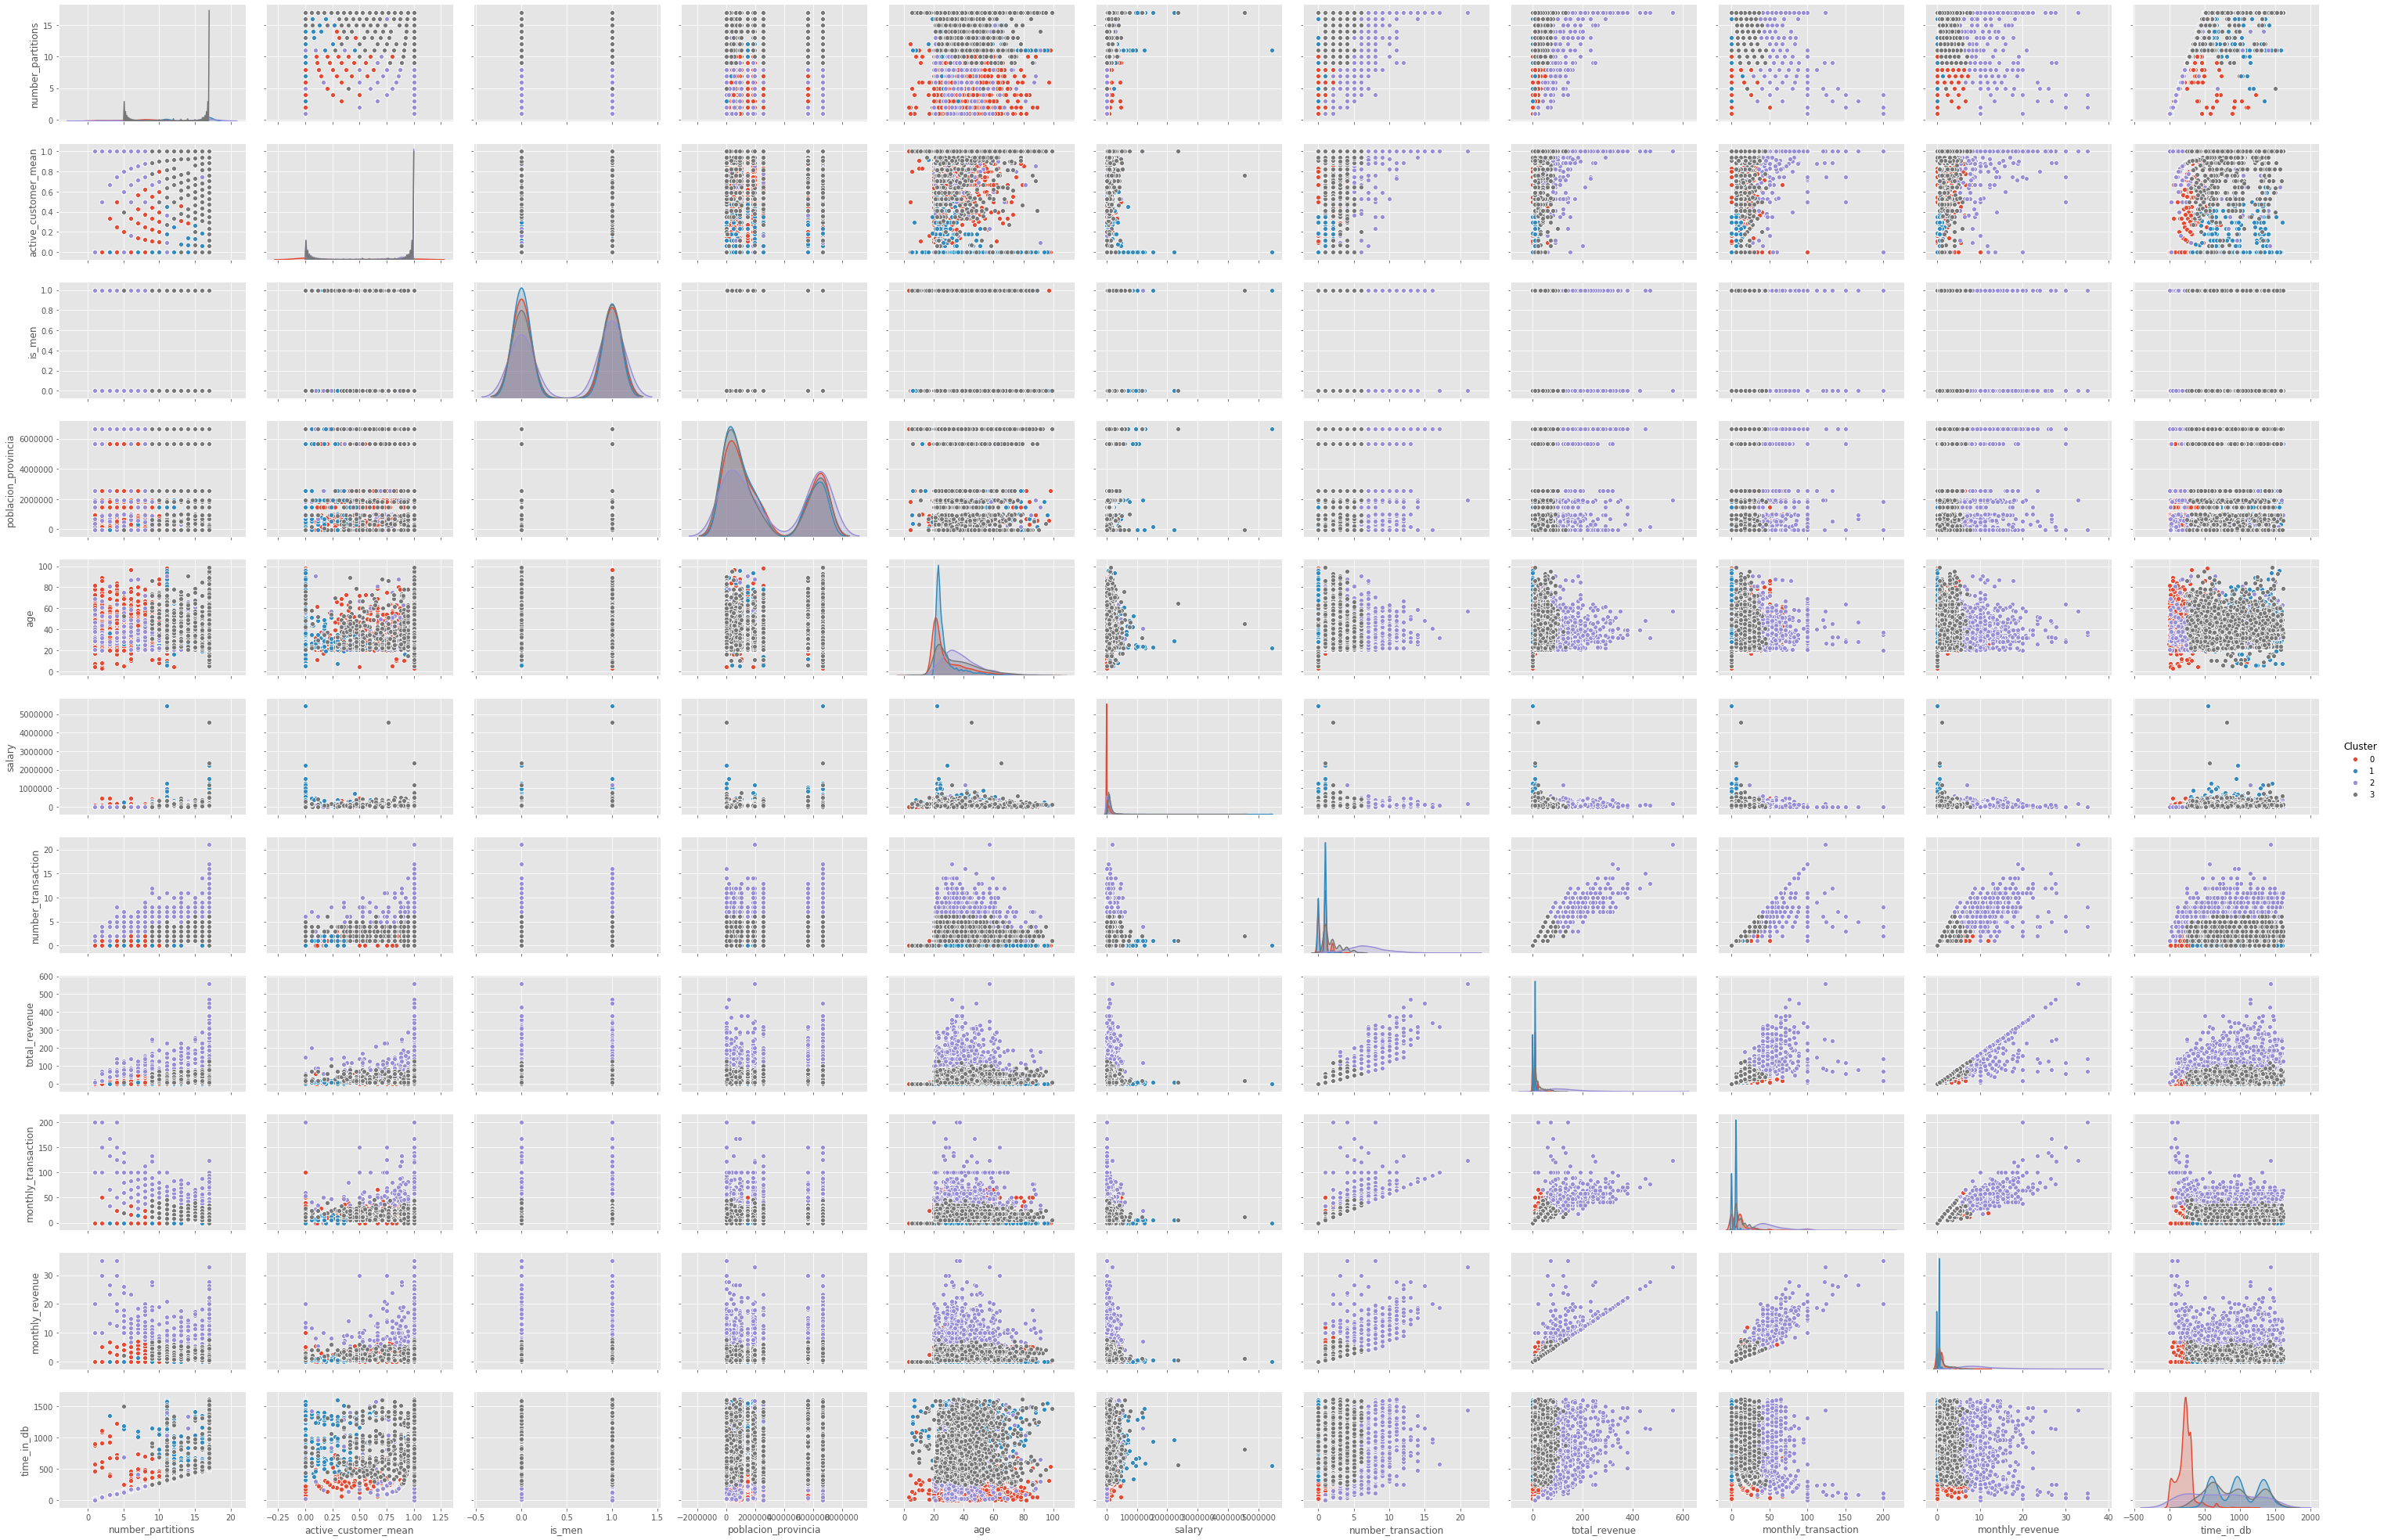

In [133]:
sns.pairplot(df_cluster.sample(10000), vars=['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue', 'monthly_transaction',
       'monthly_revenue', 'time_in_db'], hue="Cluster", aspect=1.5)
plt.show()

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

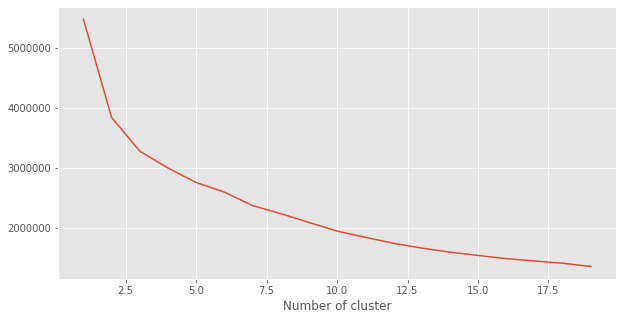

In [134]:
sse = {}

for k in range(1, 20):
    pipe = Pipeline(
            steps=[
                ('StandardScaler', StandardScaler()),
                ('KMeans', KMeans(n_clusters=k))
            ]
        ).fit(df_cluster)
    df_cluster['Cluster'] = pipe['KMeans'].labels_
    sse[k] = pipe['KMeans'].inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [134]:
df_cluster = df_agg[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue', 'monthly_transaction',
       'monthly_revenue', 'time_in_db']]

In [135]:
pipe = Pipeline(
        steps=[
       #     ('StandardScaler', StandardScaler()),
            ('KMeans', KMeans(n_clusters=10))
        ]
).fit(df_cluster)

In [136]:
df_cluster['Cluster'] = pipe.predict(df_cluster[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue', 'monthly_transaction',
       'monthly_revenue', 'time_in_db']])

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


C:\Users\charl\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\charl\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


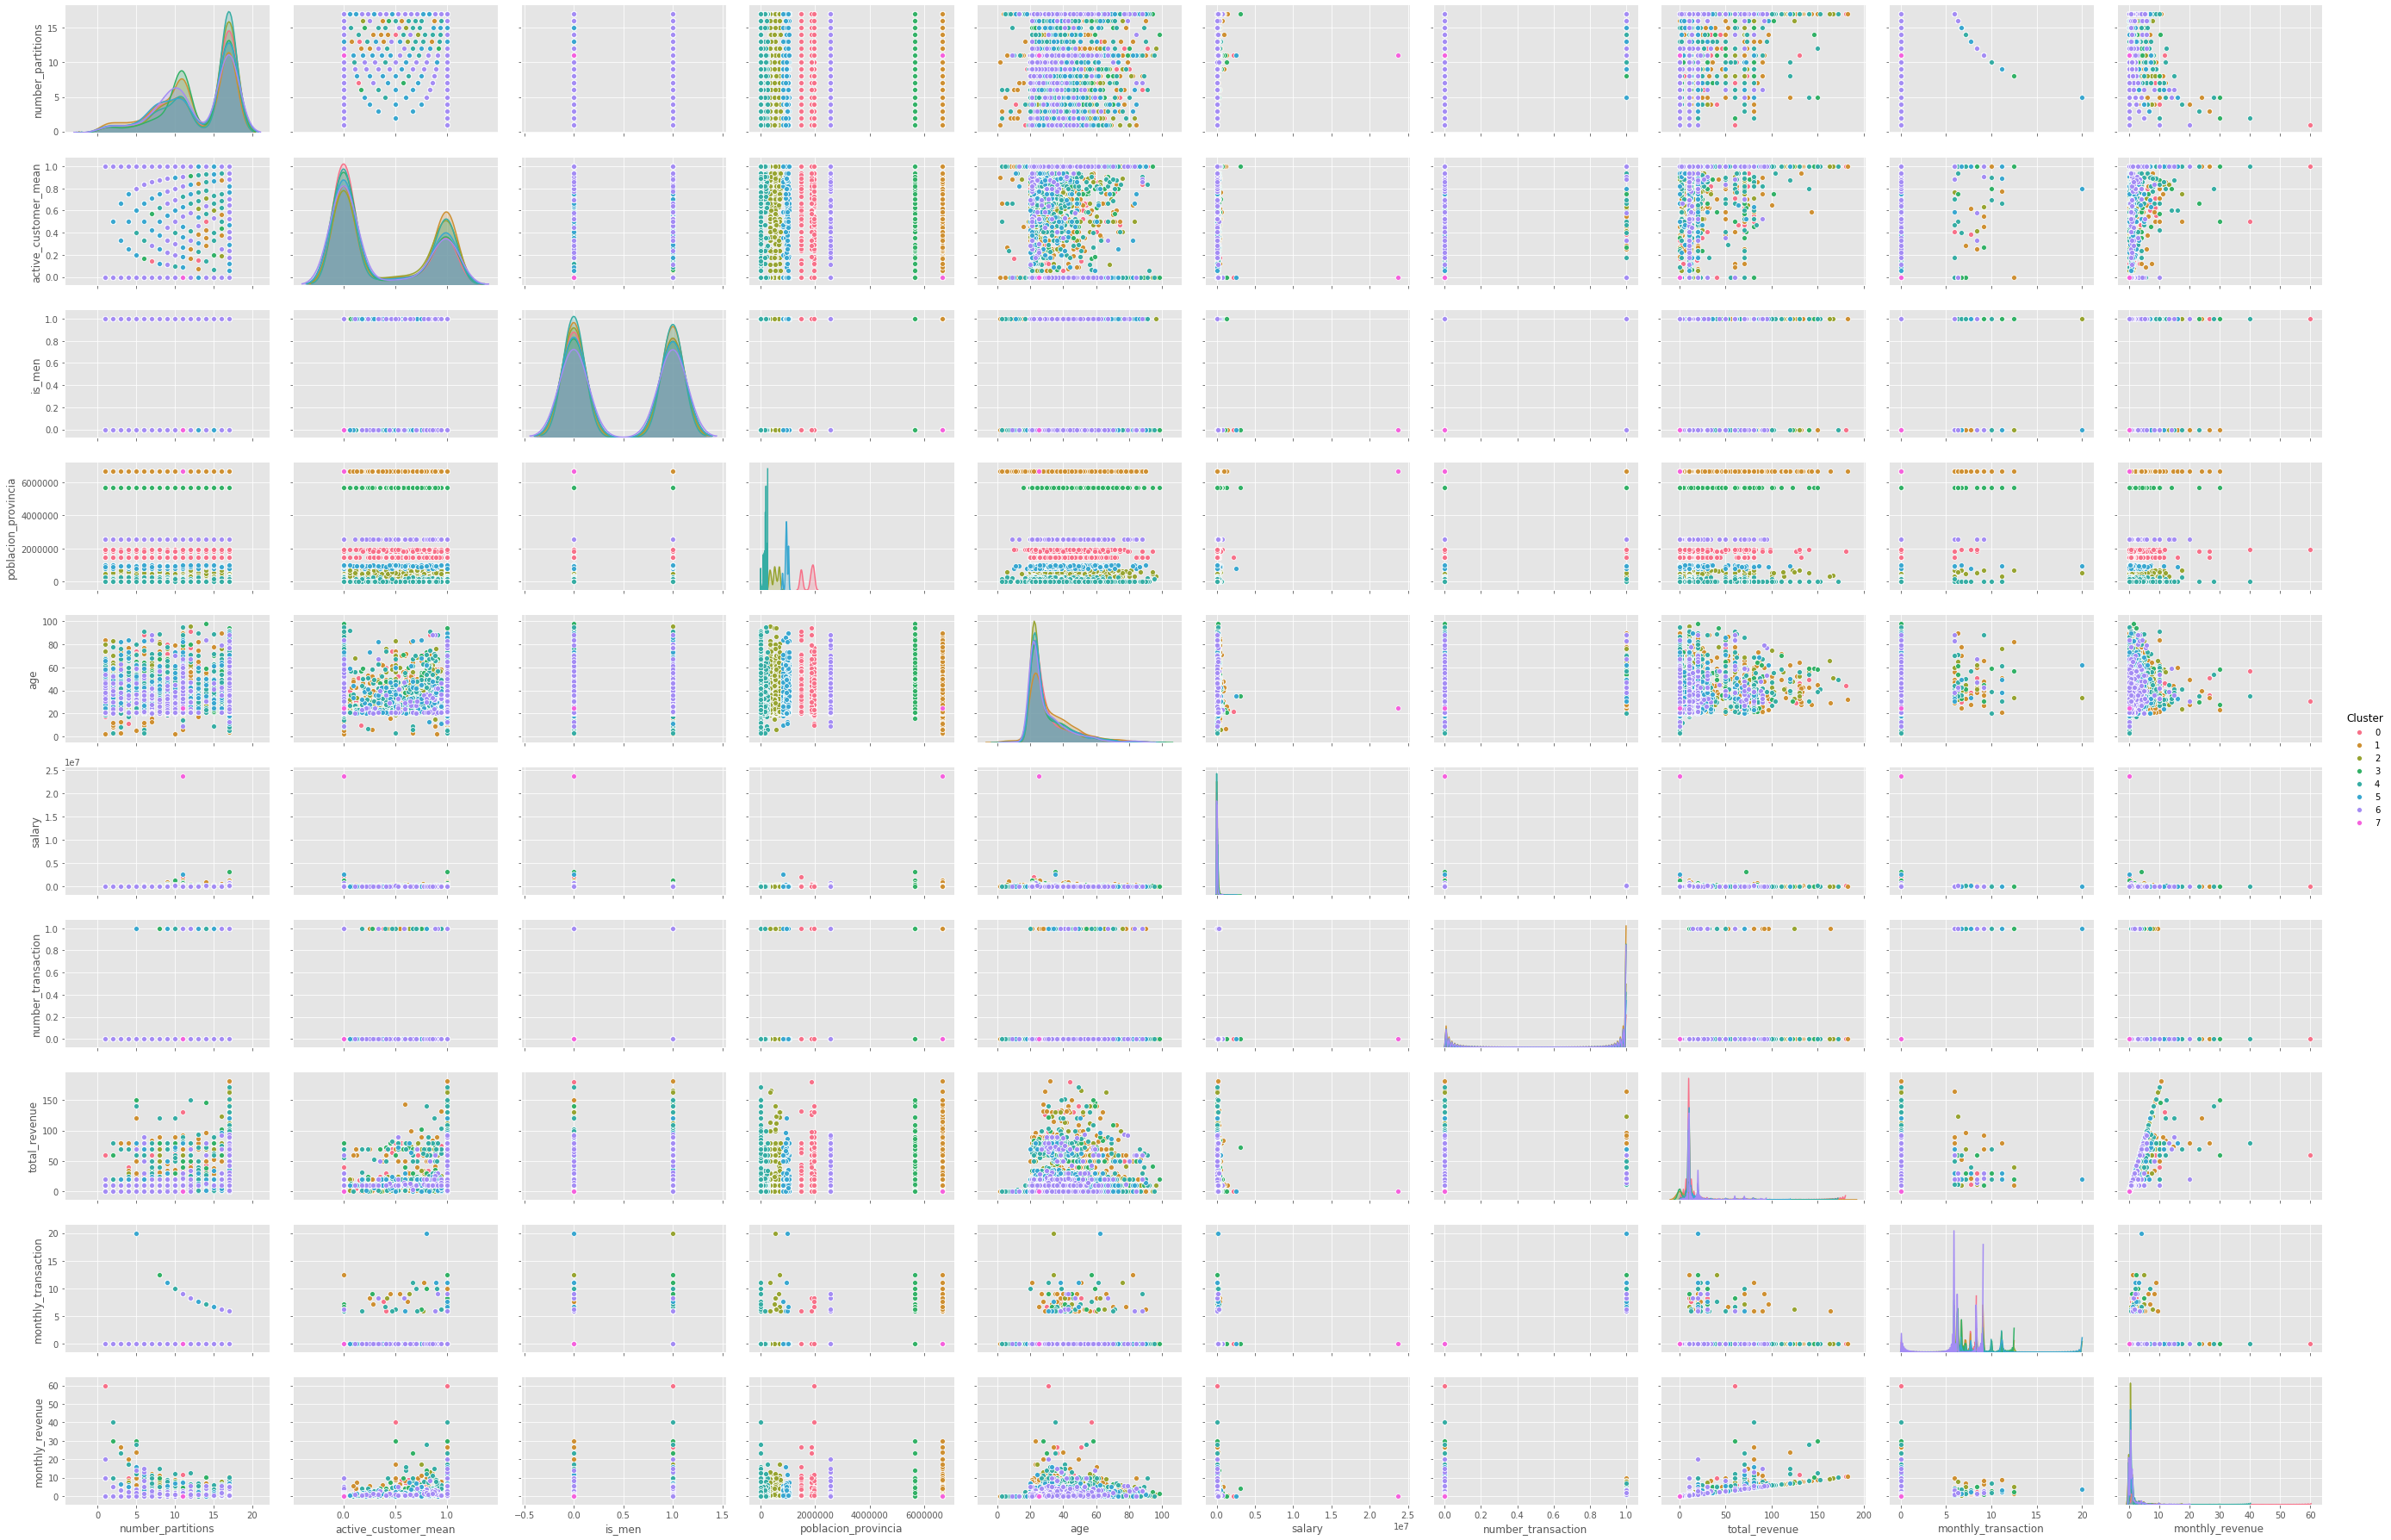

In [693]:
sns.pairplot(df_cluster.sample(10000), vars=['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue', 'monthly_transaction',
       'monthly_revenue', 'time_in_db'], hue='Cluster', aspect=1.5)
plt.show()

In [137]:
df_cluster.groupby('Cluster').agg({
    'number_partitions':'mean',
    'active_customer_mean':'mean',
    'is_men':'mean', 
    'poblacion':'mean', 
    'age':'mean', 
    'salary':'mean',
    'number_transaction':'mean', 
    'total_revenue':'mean', 
    'monthly_transaction':'mean',
    'monthly_revenue':'mean',
    'time_in_db':'mean'
})

,number_partitions,active_customer_mean,is_men,poblacion_provincia,age,salary,number_transaction,total_revenue,monthly_transaction,monthly_revenue,time_in_db
Cluster,,,,,,,,,,,
0,13.139220,0.372321,0.481767,9.511586e+05,29.859879,6.266601e+04,1.329596,17.352670,0.111302,1.406257,703.220848
1,12.072137,0.435326,0.489098,6.663394e+06,33.434485,1.063136e+05,1.538096,24.918183,0.131058,1.988812,686.069488
2,13.445553,0.390961,0.483501,2.197562e+04,30.140140,5.901929e+04,1.379333,18.381449,0.112458,1.454385,748.154735
3,13.275522,0.357904,0.507161,1.909967e+06,30.972767,6.624364e+04,1.499166,20.367516,0.122952,1.612435,717.110542
4,13.018696,0.318209,0.496421,5.664579e+06,30.105518,1.158959e+05,1.180627,16.522362,0.094468,1.281486,782.487594
5,12.922577,0.347567,0.500722,2.565124e+06,29.603868,5.604806e+04,1.410383,19.110325,0.117403,1.527706,645.089328
6,12.714286,0.507937,0.428571,6.663394e+06,28.285714,2.445647e+07,1.142857,11.428571,0.082453,0.824535,654.857143
7,13.629377,0.421596,0.478803,5.279368e+05,29.123448,5.655740e+04,1.370855,17.826376,0.110154,1.395573,758.523328
8,13.643244,0.256190,0.475414,1.493898e+06,28.086581,4.653962e+04,1.252298,15.269761,0.101512,1.213587,725.889338


##### Utilizando el dataset solo con los clientes que han generado alguna compra

In [182]:
df_cluster = df_agg[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue',
       'time_in_db']]

In [183]:
df_cluster_active = df_cluster[df_cluster['number_transaction']>0]

In [184]:
pipe = Pipeline(
        steps=[
       #     ('StandardScaler', StandardScaler()),
            ('KMeans', KMeans(n_clusters=5))
        ]
).fit(df_cluster_active)

In [185]:
df_cluster_active['Cluster'] = pipe.predict(df_cluster_active[['number_partitions',
       'active_customer_mean',
       'is_men', 'poblacion', 'age', 'salary',
       'number_transaction', 'total_revenue',
       'time_in_db']])

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [186]:
df_cluster_active.groupby('Cluster').agg({
    'number_partitions':'mean',
    'active_customer_mean':'mean',
    'is_men':'mean', 
    'poblacion':['min', 'max', 'median'], 
    'age':['min', 'max', 'median'], 
    'salary':['min', 'max', 'median'],
    'number_transaction':['min', 'max', 'mean'], 
    'total_revenue':['min', 'max', 'mean'], 
    'time_in_db':'mean'
})

number_partitions active_customer_mean    is_men poblacion_provincia  \
                     mean                 mean      mean                 min   
Cluster                                                                        
0               14.629273             0.459144  0.493636           5664579.0   
1               14.280952             0.454240  0.479119            495761.0   
2               13.742842             0.675369  0.509803           6663394.0   
3               14.207946             0.393296  0.490988           1493898.0   
4               14.425349             0.484535  0.470897              -999.0   

                              age             salary                           \
               max     median min  max median    min          max      median   
Cluster                                                                         
0        5664579.0  5664579.0  18  102     25 -999.0   5649552.45  102679.410   
1        1032983.0   804664.0   5  105     24 -999.0   8516912.52   57235.575   
2        6663394.0  6663394.0   3  104     32 -999.0  28894395.51   91366.575   
3        2565124.0  1942389.0  17   99     25 -999.0  11341152.48   53148.960   
4         388167.0     -999.0   5  103     24 -999.0  15711716.46   55992.780   

        number_transaction                 total_revenue                    \
                       min   max      mean           min    max       mean   
Cluster                                                                      
0                      1.0  25.0  1.727994          10.0  550.0  24.182141   
1                      1.0  20.0  1.638885          10.0  530.0  21.474820   
2                      1.0  21.0  2.488187          10.0  620.0  40.306765   
3                      1.0  21.0  1.709713          10.0  600.0  22.659855   
4                      1.0  21.0  1.654478          10.0  530.0  21.887201   

         time_in_db  
               mean  
Cluster              
0        821.353141  
1        750.269109  
2        732.985551  
3        718.650937  
4        769.574955

##### Quitamos los que nunca han comprado y aplicamos Undersampling con transacciones = 1

In [384]:
df_cluster = df_agg[[
       'is_men', 
        #'poblacion', 
        'age', 
        'salary',
        'number_transaction', 
        #'total_revenue', 
        'products_10',
        'products_40', 
        'products_60', 
        #'time_in_db'
        ]]

In [385]:
df_cluster['number_transaction'].value_counts()

1.0     254612
0.0     105989
2.0      37003
3.0      16967
4.0      12344
5.0       9134
6.0       6539
7.0       4588
8.0       3252
9.0       2143
10.0      1384
11.0       945
12.0       579
13.0       343
14.0       231
15.0       150
16.0        79
17.0        42
18.0        24
19.0        14
21.0         5
20.0         5
25.0         1
Name: number_transaction, dtype: int64

In [386]:
df_cluster[df_cluster['number_transaction']==3]['age'].describe()

count    16967.000000
mean        40.047504
std         14.791640
min          4.000000
25%         29.000000
50%         38.000000
75%         48.000000
max        102.000000
Name: age, dtype: float64

In [387]:
df_cluster_trans_1 = df_cluster[df_cluster['number_transaction'] == 1]

In [388]:
df_cluster_trans_1_sample = df_cluster_trans_1.sample(frac=1, random_state=42)

In [389]:
df_cluster_samp = df_cluster[df_cluster['number_transaction']>1].append(df_cluster_trans_1_sample)

In [390]:
df_cluster_samp['number_transaction'].value_counts()

1.0     254612
2.0      37003
3.0      16967
4.0      12344
5.0       9134
6.0       6539
7.0       4588
8.0       3252
9.0       2143
10.0      1384
11.0       945
12.0       579
13.0       343
14.0       231
15.0       150
16.0        79
17.0        42
18.0        24
19.0        14
21.0         5
20.0         5
25.0         1
Name: number_transaction, dtype: int64

In [391]:
pipe = Pipeline(
        steps=[
       #     ('StandardScaler', StandardScaler()),
            ('KMeans', KMeans(n_clusters=8))
        ]
).fit(df_cluster_samp[[
       'is_men', 
        #'poblacion', 
        'age', 
        'salary',
        #'number_transaction', 
        #'total_revenue', 
        'products_10',
        'products_40', 
        'products_60', 
        #'time_in_db'
        ]])

In [392]:
df_cluster_samp['Cluster'] = pipe.predict(df_cluster_samp[['is_men', 
       #'poblacion', 
       'age', 
       'salary',
       #'number_transaction', 
        #'total_revenue', 
        'products_10',
        'products_40', 'products_60', 
        #'time_in_db'
        ]])

In [393]:
df_cluster_samp.groupby('Cluster').agg({
    'is_men':'mean', 
    #'poblacion':'median', 
    'age':'mean', 
    'salary':'mean',
    #'number_transaction':'mean', 
    #'total_revenue':'mean', 
    'products_10': 'mean',
    'products_40': 'mean', 
    'products_60': 'mean'
})

,is_men,age,salary,products_10,products_40,products_60
Cluster,,,,,,
0,0.480424,30.229813,8.145657e+04,1.660099,0.186151,0.046223
1,0.500000,24.500000,2.421415e+07,2.000000,0.000000,0.000000
2,0.496432,31.589624,4.108613e+05,1.707659,0.245677,0.078918
3,0.524590,31.393443,4.180268e+06,2.016393,0.163934,0.065574
4,0.484376,30.499426,4.748805e+03,1.475530,0.123200,0.023611
5,0.240000,34.560000,1.088030e+07,1.960000,0.040000,0.040000
6,0.503116,31.651835,1.802533e+05,1.724374,0.241633,0.069240
7,0.486224,31.852512,1.160504e+06,1.735818,0.209076,0.048622


##### El sueldo es un factor importante. Veamos que pasa con los pk_cid sin sueldo. 

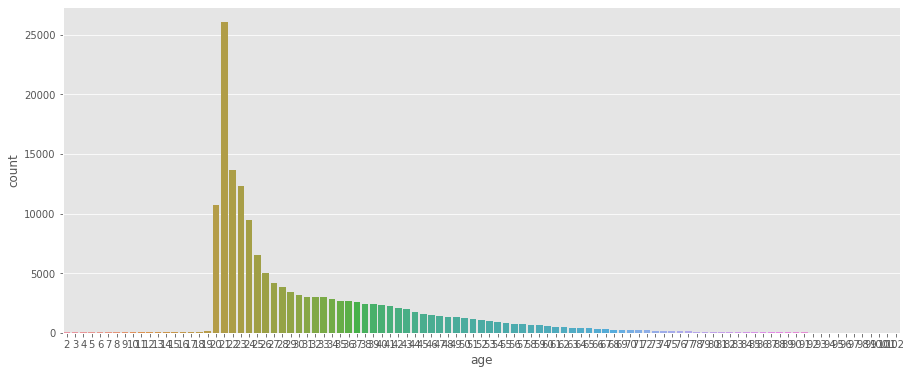

In [131]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']<0], x='age')

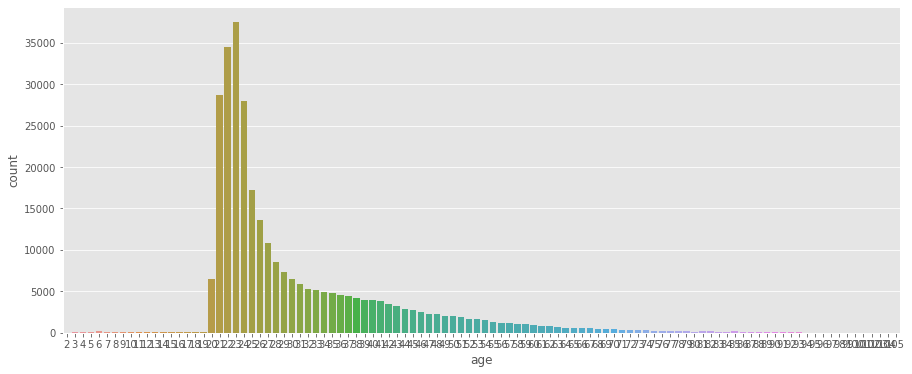

In [132]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']>0], x='age')

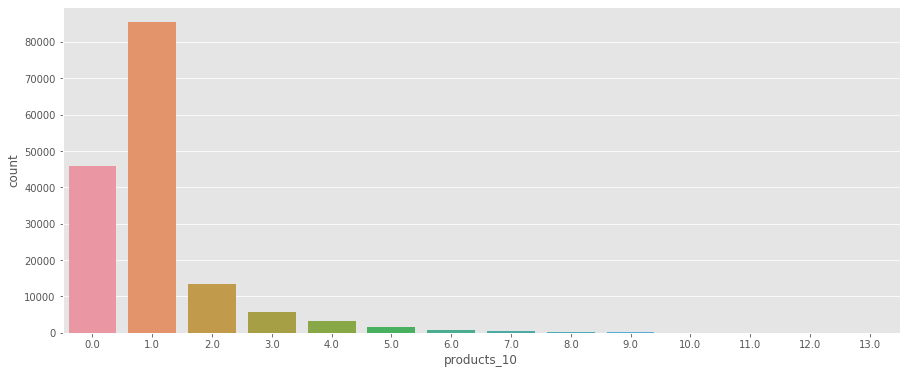

In [137]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']<0], x='products_10')

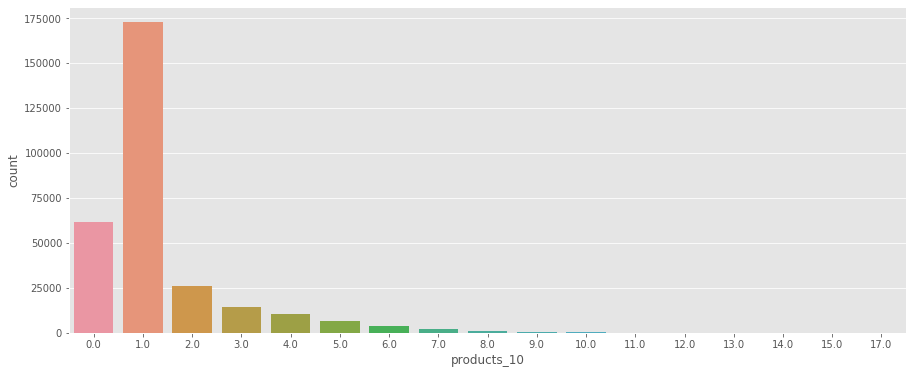

In [138]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']>0], x='products_10')

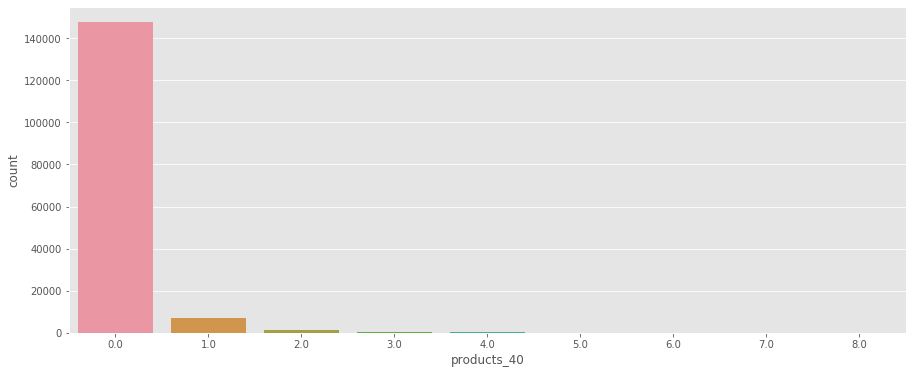

In [139]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']<0], x='products_40')

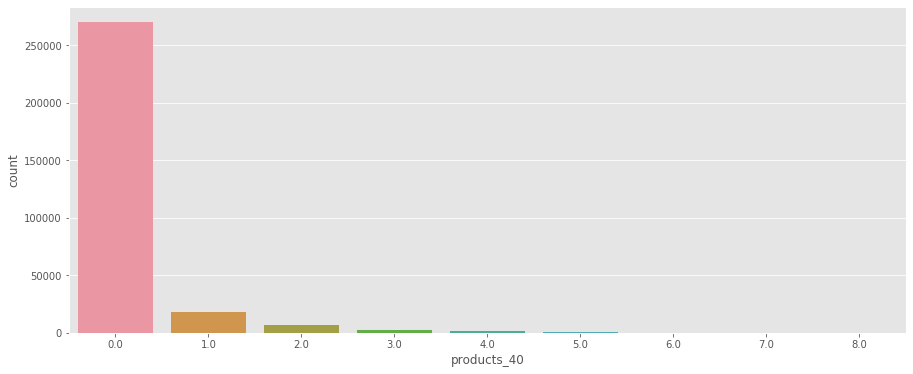

In [140]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']>0], x='products_40')

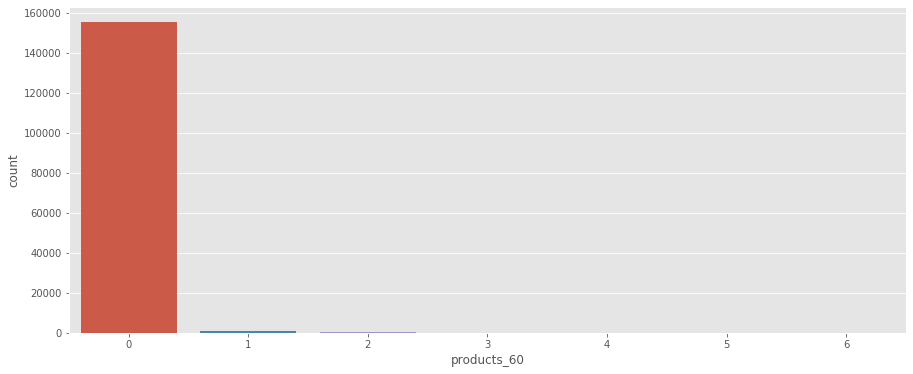

In [141]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']<0], x='products_60')

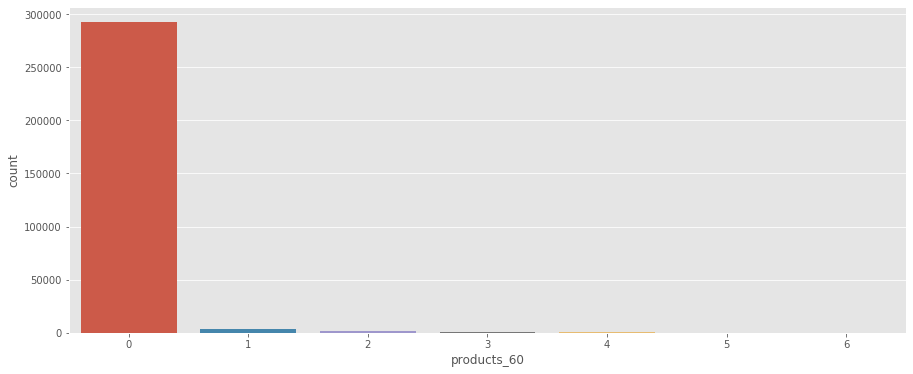

In [142]:
plt.figure(figsize= [15, 6])
sns.countplot(data=df_agg[df_agg['salary']>0], x='products_60')